# ——  基于文本挖掘的电商产品评论数据情感分析  ——

### 1.案例简介

    1、利用文本挖掘技术，对碎片化、非结构化的电商网站评论数据进行清洗与处理，转化为结构化数据。
    2、参考知网发布的情感分析用词语集，统计评论数据的正负情感指数，然后进行情感分析,通过词云图直观查看正负评论的关键词。
    3、比较“机器挖掘的正负情感”与“人工打标签的正负情感”，精度达到89%。
    4、采用LDA主题模型提取评论关键信息
   

### 2.目录

    工具准备
    
    一、导入数据
    二、数据预处理
        （一）去重
        （二）数据清洗
        （三）分词、词性标注、去除停用词、词云图
    三、模型构建
        （一）决策树
        （二）情感分析
        （三）基于LDA模型的主题分析

## 工具准备

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import style #自定义图表风格
style.use('ggplot')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams['font.sans-serif'] = ['Simhei'] # 解决中文乱码问题
import re
import jieba.posseg as psg
import itertools
#conda install -c anaconda gensim
from gensim import corpora,models #主题挖掘，提取关键信息

# pip install wordcloud
from wordcloud import WordCloud,ImageColorGenerator
from collections import Counter

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import graphviz


## 一、导入数据

In [4]:
raw_data=pd.read_csv('./jd_P/data100.csv')
raw_data.head()

,Unnamed: 0,id,nickname,creationTime,productColor,尺码,score,referenceName,content,content_type
0,0,1.756192e+10,j***c,2022-05-31 14:34:07,秋蓝黑茶短【升级3C款】,均码,5.0,Andes HELMET电动车头盔男四季女士夏季头盔轻便式安全帽四季通用夏天半盔 哑黑黑茶短...,买的第二个了 第一个买的黑色的 这次买的是蓝色的 这个头盔质量非常不错 卖家也很好 发货速度也很快,pos
1,1,1.541318e+10,x***r,2021-03-12 20:02:52,灰色黑茶中,均码,5.0,Andes HELMET电动车头盔男四季女士夏季头盔轻便式安全帽四季通用夏天半盔 哑黑黑茶短...,电动车头盔男四季防晒防雨电瓶车头盔女士夏季哈雷头盔轻便式半覆式安全帽四季通用半盔防晒夏天 灰...,pos
2,2,1.861429e+10,随***2,2022-12-27 15:49:53,秋蓝黑茶短【升级3C款】,均码,5.0,Andes HELMET电动车头盔男四季女士夏季头盔轻便式安全帽四季通用夏天半盔 哑黑黑茶短...,东西很不错，灰色高端大气上档次。比买电动车送的那个好太多了，还会再来,pos
3,3,1.755905e+10,小***行,2022-05-30 19:35:32,哑黑黑茶短【升级3C款】,均码,5.0,Andes HELMET电动车头盔男四季女士夏季头盔轻便式安全帽四季通用夏天半盔 哑黑黑茶短...,头盔质量还挺好，比较厚实，内衬也比较舒适。磨砂的哑黑。还挺好看的。,pos
4,4,1.755236e+10,一***秋,2022-05-29 09:48:41,灰色黑茶短【升级3C款】,均码,5.0,Andes HELMET电动车头盔男四季女士夏季头盔轻便式安全帽四季通用夏天半盔 哑黑黑茶短...,这个价位的头盔可以说绝对良心商家，头盔外观漂亮大气，做工精细，还很贴心送了一些装饰，而且质量...,pos


In [6]:
#取值分布
for cate in ['creationTime', 'nickname', 'productColor', 'content_type']:
    raw_data[cate].value_counts()

2018-05-19 21:18:07    2
2022-06-16 00:08:02    2
2023-04-24 19:10:32    2
2022-09-13 12:38:37    2
2022-07-30 21:07:02    2
                      ..
2022-05-07 23:46:17    1
2022-07-07 00:07:15    1
2018-06-10 20:15:44    1
2021-11-14 15:35:28    1
2023-05-09 09:30:09    1
Name: creationTime, Length: 716, dtype: int64

j***o    14
j***f    13
j***2    11
j***r    10
j***e    10
         ..
1***陈     1
j***Q     1
程***里     1
一***友     1
j***娜     1
Name: nickname, Length: 482, dtype: int64

哑黑黑茶短【升级3C款】    198
哑黑黑茶短           157
米白黑茶短【升级3C款】     46
哑黑透明短            42
哑黑               37
               ... 
黄色透明短             1
哑黑(透明短)           1
白花(中镜)            1
笑脸黑透短             1
哑黑秋冬款【3C款】        1
Name: productColor, Length: 84, dtype: int64

pos    482
neg    351
Name: content_type, dtype: int64

## 二、数据预处理

### （一）去重

删除系统自动为客户做出的评论。

In [7]:
reviews=raw_data.copy()
reviews=reviews[['content', 'content_type']]
print('去重之前：',reviews.shape[0])
reviews=reviews.drop_duplicates()
print('去重之后：',reviews.shape[0])

去重之前： 833
去重之后： 645


### （二）数据清洗

In [8]:
# 清洗之前
content=reviews['content']
for i in range(5,10):
    print(content[i])
    print('-----------')

这款安全帽子还可以的，在此之前在其他平台也买了，但是质量没有这个好，退掉了，又在京东上买的，这个价位的话相比同产品还是不错，现在不买头盔不行，查得紧。
-----------
刚刚收到货 第一时间打开  没有失望  性价比高得很  质量没的说  值得购买
-----------
头盔看着很结实，也很厚实，颜色也很喜欢，重量也合适
-----------
他俩质量蛮不错的，一下在两家店铺拍了，一对比，另外一个果断退过了，太差了虽然质量也便宜一些，确实质量差的有点多，镜片要去看透明，不喜欢，和客服沟通了。可以换货，不错的购物体验
-----------
非常好用，颜色漂亮，戴起来舒服，尤其是后面有反光板，灯光照射下可以被发现，起到反光警示作用，前挡风遮雨板非常方便拆卸，物美价廉，经济实惠，活动买的价格美丽，支持京东商城，支持国货精品店，谢谢!
-----------


In [9]:
#清洗之后，将数字字样都删除
info=re.compile('[0-9a-zA-Z]|京东|头盔|第一|第二|质量|客服|包邮')
content=content.apply(lambda x: info.sub('',x))  #替换所有匹配项

for i in range(5,10):
    print(content[i])
    print('-----------')

这款安全帽子还可以的，在此之前在其他平台也买了，但是没有这个好，退掉了，又在上买的，这个价位的话相比同产品还是不错，现在不买不行，查得紧。
-----------
刚刚收到货 时间打开  没有失望  性价比高得很  没的说  值得购买
-----------
看着很结实，也很厚实，颜色也很喜欢，重量也合适
-----------
他俩蛮不错的，一下在两家店铺拍了，一对比，另外一个果断退过了，太差了虽然也便宜一些，确实差的有点多，镜片要去看透明，不喜欢，和沟通了。可以换货，不错的购物体验
-----------
非常好用，颜色漂亮，戴起来舒服，尤其是后面有反光板，灯光照射下可以被发现，起到反光警示作用，前挡风遮雨板非常方便拆卸，物美价廉，经济实惠，活动买的价格美丽，支持商城，支持国货精品店，谢谢!
-----------


### （三）分词、词性标注、去除停用词、词云图

(1)分词

目标
   
    输入：
    - content、content_type
    输出：
    - 构造DF，包含： 分词、对应词性、分词所在原句子的id、分词所在原句子的content_type
    非结构化数据——>结构化数据

In [11]:
#分词，由元组组成的list
seg_content=content.apply( lambda s:  [(x.word,x.flag) for x in psg.cut(s)] )  

seg_content.shape
len(seg_content)
print(seg_content[5])

(645,)

645

[('这', 'r'), ('款', 'm'), ('安全', 'an'), ('帽子', 'n'), ('还', 'd'), ('可以', 'c'), ('的', 'uj'), ('，', 'x'), ('在此之前', 'i'), ('在', 'p'), ('其他', 'r'), ('平台', 'n'), ('也', 'd'), ('买', 'v'), ('了', 'ul'), ('，', 'x'), ('但是', 'c'), ('没有', 'v'), ('这个', 'r'), ('好', 'a'), ('，', 'x'), ('退掉', 'v'), ('了', 'ul'), ('，', 'x'), ('又', 'd'), ('在', 'p'), ('上买', 'v'), ('的', 'uj'), ('，', 'x'), ('这个', 'r'), ('价位', 'n'), ('的话', 'u'), ('相比', 'v'), ('同', 'p'), ('产品', 'n'), ('还是', 'c'), ('不错', 'a'), ('，', 'x'), ('现在', 't'), ('不', 'd'), ('买', 'v'), ('不行', 'v'), ('，', 'x'), ('查得', 'v'), ('紧', 'a'), ('。', 'x')]


In [13]:
#统计评论词数
n_word=seg_content.apply(lambda s: len(s))

len(n_word)
n_word.head(6)

645

0    31
1    55
2    24
3    21
4    31
5    46
Name: content, dtype: int64

In [14]:
#得到各分词在第几条评论
n_content=[ [x+1]*y for x,y in zip(list(seg_content.index),list(n_word))] #[x+1]*y,表示复制y份，由list组成的list
index_content_long=sum(n_content,[]) #表示去掉[]，拉平,返回list
len(index_content_long)

17113

In [15]:
sum([[2,2],[3,3,3]],[])

[2, 2, 3, 3, 3]

In [16]:
#分词及词性，去掉[]，拉平
seg_content.head()

seg_content_long=sum(seg_content,[])

seg_content_long

type(seg_content_long)
len(seg_content_long)

0    [(买, v), (的, uj), (个, q), (了, ul), ( , x), (个,...
1    [(电动车, n), (男, n), (四季, m), (防晒, v), (防雨, n), ...
2    [(东西, ns), (很, zg), (不错, a), (，, x), (灰色, n), ...
3    [(还, d), (挺, d), (好, a), (，, x), (比较, d), (厚实,...
4    [(这个, r), (价位, n), (的, uj), (可以, c), (说, v), (...
Name: content, dtype: object

[('买', 'v'),
 ('的', 'uj'),
 ('个', 'q'),
 ('了', 'ul'),
 (' ', 'x'),
 ('个', 'm'),
 ('买', 'v'),
 ('的', 'uj'),
 ('黑色', 'n'),
 ('的', 'uj'),
 (' ', 'x'),
 ('这次', 'r'),
 ('买', 'v'),
 ('的', 'uj'),
 ('是', 'v'),
 ('蓝色', 'n'),
 ('的', 'uj'),
 (' ', 'x'),
 ('这个', 'r'),
 ('非常', 'd'),
 ('不错', 'a'),
 (' ', 'x'),
 ('卖家', 'n'),
 ('也', 'd'),
 ('很', 'd'),
 ('好', 'a'),
 (' ', 'x'),
 ('发货', 'n'),
 ('速度', 'n'),
 ('也', 'd'),
 ('很快', 'd'),
 ('电动车', 'n'),
 ('男', 'n'),
 ('四季', 'm'),
 ('防晒', 'v'),
 ('防雨', 'n'),
 ('电瓶车', 'n'),
 ('女士', 'n'),
 ('夏季', 't'),
 ('哈雷', 'nr'),
 ('轻便式', 'l'),
 ('半', 'm'),
 ('覆式', 'n'),
 ('安全帽', 'nz'),
 ('四季', 'm'),
 ('通用', 'v'),
 ('半盔', 'n'),
 ('防晒', 'v'),
 ('夏天', 't'),
 (' ', 'x'),
 ('灰色', 'n'),
 ('黑', 'a'),
 ('茶', 'n'),
 ('中', 'f'),
 (' ', 'x'),
 ('均码', 'n'),
 ('不错', 'a'),
 ('的', 'uj'),
 ('一款', 'm'),
 ('，', 'x'),
 ('算得', 'v'),
 ('上', 'f'),
 ('一款', 'm'),
 ('物美', 'nz'),
 ('廉价', 'n'),
 ('，', 'x'),
 ('做工', 'v'),
 ('不错', 'a'),
 ('，', 'x'),
 ('款式', 'n'),
 ('较为', 'd'),
 ('新颖', 'a'),
 ('的', 'uj'

list

17113

In [17]:
seg_content_long[0]

('买', 'v')

In [18]:
#得到加长版的分词、词性
word_long=[x[0] for x in seg_content_long]
nature_long=[x[1] for x in seg_content_long]

len(word_long)
len(nature_long)

17113

17113

In [19]:
#content_type拉长
n_content_type=[ [x]*y for x,y in zip(list(reviews['content_type']),list(n_word))] #[x+1]*y,表示复制y份
content_type_long=sum(n_content_type,[]) #表示去掉[]，拉平

len(content_type_long)

17113

In [20]:
review_long=pd.DataFrame({'index_content':index_content_long,
                        'word':word_long,
                        'nature':nature_long,
                        'content_type':content_type_long})
review_long.shape
review_long.head()

(17113, 4)

,index_content,word,nature,content_type
0,1,买,v,pos
1,1,的,uj,pos
2,1,个,q,pos
3,1,了,ul,pos
4,1,,x,pos


（2）去除标点符号、去除停用词

In [21]:
review_long['nature'].unique()

array(['v', 'uj', 'q', 'ul', 'x', 'm', 'n', 'r', 'd', 'a', 't', 'nr', 'l',
       'nz', 'f', 'uz', 'ns', 'zg', 'b', 'p', 'z', 'c', 'an', 'i', 'u',
       'ud', 'ad', 'ng', 'vn', 'df', 'j', 'y', 's', 'ug', 'mq', 'nrt',
       'o', 'e', 'k', 'vg', 'g', 'uv', 'dg', 'yg', 'tg', 'ag'],
      dtype=object)

In [22]:
#去除标点符号
review_long_clean=review_long[review_long['nature']!='x'] #x表示标点符合
review_long_clean.shape

(13645, 4)

In [23]:
#导入停用词
stop_path=open('./stoplist.txt','r',encoding='UTF-8')
stop_words=stop_path.readlines()

len(stop_words)
stop_words[0:5]

5748

['\ufeff \n', '说\n', '人\n', '元\n', 'hellip\n']

In [24]:
#停用词，预处理
stop_words=[word.strip('\n') for word in stop_words]
stop_words[0:5]

['\ufeff ', '说', '人', '元', 'hellip']

In [25]:
#得到不含停用词的分词表
word_long_clean=list(set(word_long)-set(stop_words))
len(word_long_clean)

review_long_clean=review_long_clean[review_long_clean['word'].isin(word_long_clean)]
review_long_clean.shape

2003

(7000, 4)

(3)在原df中，再增加一列，该分词在本条评论的位置

In [26]:
#再次统计每条评论的分词数量
n_word=review_long_clean.groupby('index_content').count()['word']
n_word

index_word=[ list(np.arange(1,x+1)) for x in list(n_word)] 
index_word_long=sum(index_word,[]) #表示去掉[]，拉平

len(index_word_long)

index_content
1       7
2      37
3       9
4       6
5      14
       ..
823     7
824     2
826     9
827    14
828    10
Name: word, Length: 637, dtype: int64

7000

In [27]:
review_long_clean['index_word']=index_word_long
review_long_clean.head()

,index_content,word,nature,content_type,index_word
8,1,黑色,n,pos,1
15,1,蓝色,n,pos,2
20,1,不错,a,pos,3
22,1,卖家,n,pos,4
27,1,发货,n,pos,5


In [28]:
review_long_clean.to_csv('./1_review_long_clean.csv')

(4)提取名词

In [29]:
n_review_long_clean=review_long_clean[[ 'n' in nat for nat in review_long_clean.nature]]
n_review_long_clean.shape
n_review_long_clean.head()

(2827, 5)

,index_content,word,nature,content_type,index_word
8,1,黑色,n,pos,1
15,1,蓝色,n,pos,2
22,1,卖家,n,pos,4
27,1,发货,n,pos,5
28,1,速度,n,pos,6


In [30]:
n_review_long_clean.nature.value_counts()
n_review_long_clean.to_csv('./1_n_review_long_clean.csv')

n      2321
vn      174
nr      107
ns       97
nz       86
ng       30
nrt      10
an        2
Name: nature, dtype: int64

<Figure size 2000x1000 with 0 Axes>

(-0.5, 1344.5, 1344.5, -0.5)

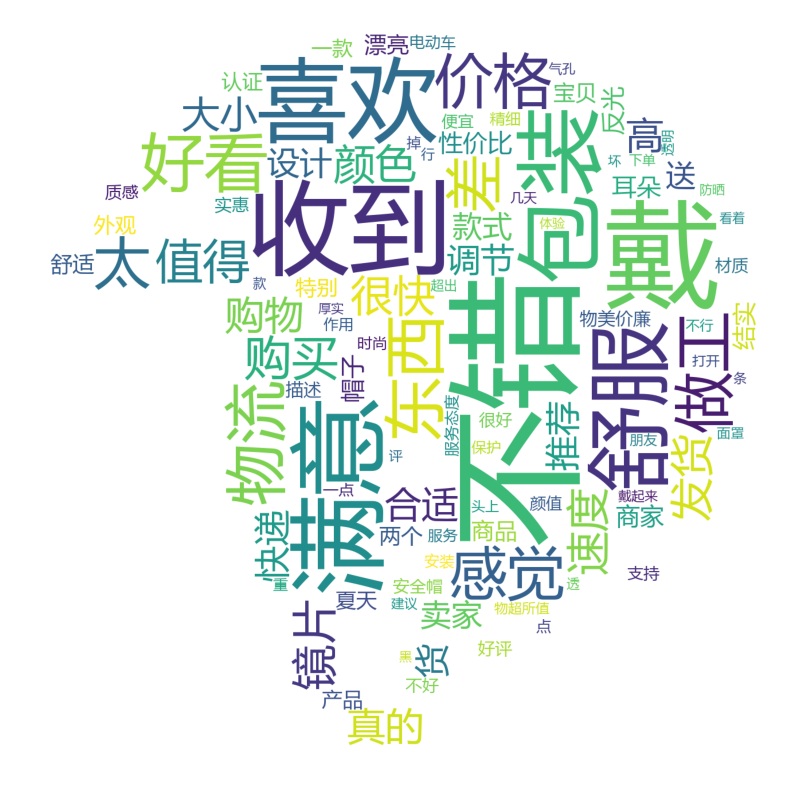

In [31]:
font=r"C:\Windows\Fonts\msyh.ttc"

background_image=plt.imread('./jd_P/p1.jpg')
wordcloud = WordCloud(font_path=font, max_words = 100, background_color='white',mask=background_image) #width=1600,height=1200, mode='RGBA'
wordcloud.generate_from_frequencies(Counter(review_long_clean.word.values))
wordcloud.to_file('1_分词后的词云图.png')

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<Figure size 2000x1000 with 0 Axes>

(-0.5, 1000.5, 1000.5, -0.5)

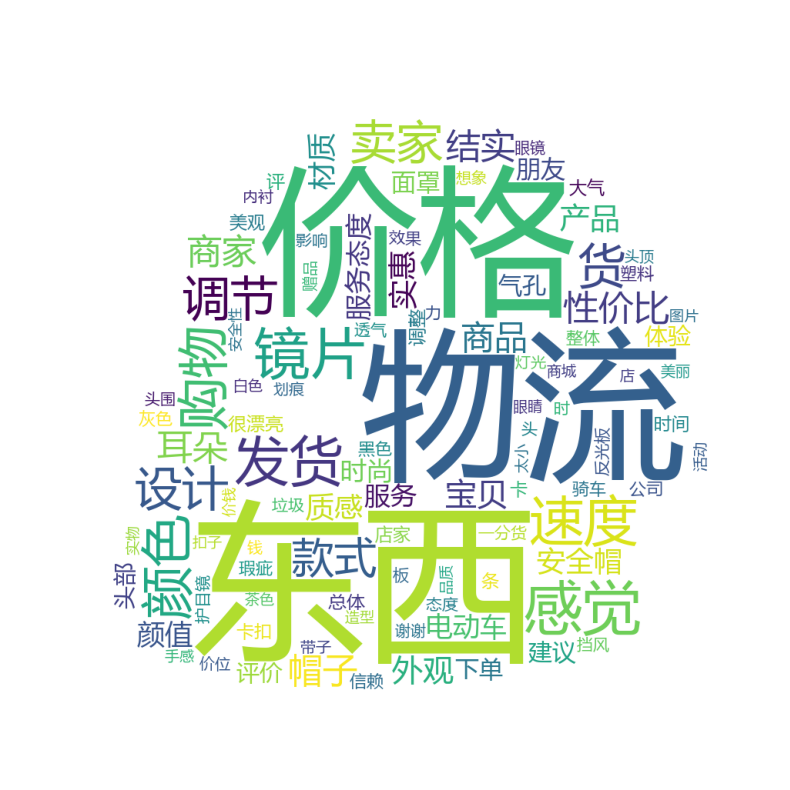

In [32]:
font=r"C:\Windows\Fonts\msyh.ttc"

background_image=plt.imread('./jd_P/p2.jpg')
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(n_review_long_clean.word.values))
wordcloud.to_file('1_分词后的词云图(名词）.png')

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 三、模型构建

### （一）基于决策树的情感分类

In [34]:
#第一步：构造特征空间和标签

Y=[]
for ind in review_long_clean.index_content.unique():
    y=[ word for word in review_long_clean.content_type[review_long_clean.index_content==ind].unique() ]
    Y.append(y)
len(Y)

X=[]
for ind in review_long_clean.index_content.unique():
    term=[ word for word in review_long_clean.word[review_long_clean.index_content==ind].values ]
    X.append(' '.join(term))
len(X)

X
Y

637

637

['黑色 蓝色 不错 卖家 发货 速度 很快',
 '电动车 男 四季 防晒 防雨 电瓶车 女士 夏季 哈雷 轻便式 覆式 安全帽 四季 通用 半盔 防晒 夏天 灰色 黑 茶 中 均码 不错 一款 算得 一款 物美 廉价 做工 不错 款式 新颖 戴 舒服 灰色 喜欢 色系',
 '东西 不错 灰色 高端 大气 上档次 电动车 送 太',
 '厚实 内衬 舒适 磨砂 哑黑 好看',
 '价位 良心 商家 外观 漂亮 大气 做工 精细 贴心 送 装饰 认证 值得 推荐',
 '款 帽子 在此之前 平台 退掉 上买 价位 相比 产品 不错 不行 查得 紧',
 '刚刚 收到 货 时间 打开 失望 性价比 高 没的说 值得 购买',
 '看着 结实 厚实 颜色 喜欢 重量 合适',
 '他俩 不错 两家 店铺 拍 果断 退过 太 差 便宜 确实 差 镜片 透明 喜欢 沟通 换货 不错 购物 体验',
 '颜色 漂亮 戴起来 舒服 反光板 灯光 照射 发现 起到 反光 警示 作用 前 挡风遮雨 板 拆卸 物美价廉 经济 实惠 活动 价格 美丽 支持 商城 支持 国货 精品店 谢谢',
 '扣 铁 难 取开 建议',
 '后悔 差 也敢 卖 想 钱 想 疯 商家 卖 假冒伪劣 产品 好评 一问三不知 半天 回复 态度 极差 退货 运费 天无 理由 退货 假 一百个 理由 不退 这家 店 欺骗 消费者',
 '泡沫 内衬 搞 假 类似 碳纤维 胶壳 充当 泡沫',
 '一颗 星星 真的 一颗 不想 告诉 一颗 星星 取消 糟糕透顶 购物 再也 网上 东西 稍微 胖 一点 戴 夏天 棉的 里 垫 带子 穿 卡 紧 易碎品 玻璃',
 '朋友 块钱 黑点 毛边 一点',
 '公平 公正 评价 帽子 放在 车筐 里 撞击 放在 车筐 里 碰 掉色',
 '溢流 毛边 出厂 面罩 听 刀 挂 面罩 扣 后悔',
 '送 风车 不错 隐形 包装 精美',
 '真的 差 不到 防护 作用 一圈 白色 头套 再就是 一层 塑料 壳 安全帽 结构 没法 安全帽 剪 标 想退 退 算了 扔掉 好评 刷',
 '差 个把月 货 收不到 钱 退 次 催 下单 后天 再慢 慢 成 天次 催单 足够 时间 耐心 问 物流 几天 主动 找 问 申请 退款 商品 拒收 行 货 钱 没退 找 申请 退款 东西 

[['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],


In [35]:
#第二步：训练集、测试集划分
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=7)

#第三步：词转向量，01矩阵
count_vec=CountVectorizer(binary=True) 
x_train=count_vec.fit_transform(x_train)
x_test=count_vec.transform(x_test)  

#第四步：构建决策树
dtc=tree.DecisionTreeClassifier(max_depth=5)
dtc.fit(x_train,y_train)
print('在训练集上的准确率：%.2f'% accuracy_score(y_train,dtc.predict(x_train)))

y_true=y_test
y_pred=dtc.predict(x_test)
print(classification_report(y_true,y_pred))
print('在测试集上的准确率：%.2f'% accuracy_score(y_true,y_pred))

DecisionTreeClassifier(max_depth=5)

在训练集上的准确率：0.80
              precision    recall  f1-score   support

         neg       0.67      0.97      0.79        61
         pos       0.95      0.57      0.71        67

    accuracy                           0.76       128
   macro avg       0.81      0.77      0.75       128
weighted avg       0.82      0.76      0.75       128

在测试集上的准确率：0.76


'C:\\Users\\Saiwei\\Untitled Folder\\Untitled Folder\\tree.svg'

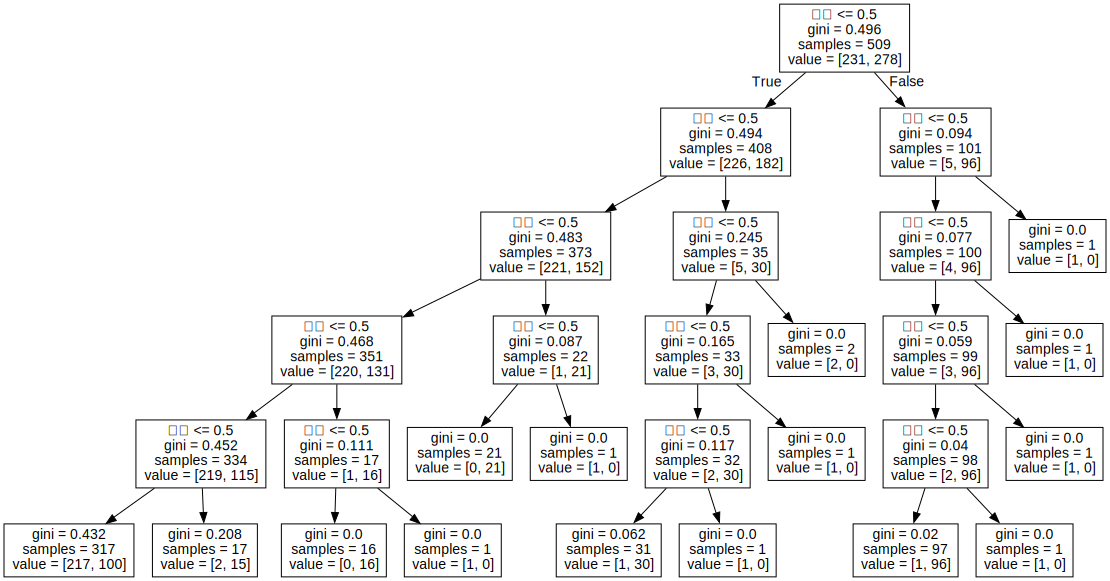

In [36]:
#第五步：画决策树

cwd=os.getcwd()
dot_data=tree.export_graphviz(dtc
                              ,out_file=None
                              ,feature_names=count_vec.get_feature_names_out())
graph=graphviz.Source(dot_data)
graph.format='svg'
graph.render(cwd+'/tree',view=True)
graph

### （二）情感分析

(1)导入评价情感词

In [37]:
#来自知网发布的情感分析用词语集

pos_comment=pd.read_csv('./正面评价词语（中文）.txt',header=None,sep='\0',encoding='utf-8') 
neg_comment=pd.read_csv('./负面评价词语（中文）.txt',header=None,sep='\0',encoding='utf-8')

pos_emotion=pd.read_csv('./正面情感词语（中文）.txt',header=None,sep='\0',encoding='utf-8')
neg_emotion=pd.read_csv('./负面情感词语（中文）.txt',header=None,sep='\0',encoding='utf-8')

In [40]:
pos_comment.shape
neg_comment.shape

pos_emotion.shape
neg_emotion.shape

(3743, 1)

(3138, 1)

(833, 1)

(1251, 1)

In [41]:
pos=pd.concat([pos_comment,pos_emotion],axis=0)
pos.shape

neg=pd.concat([neg_comment,neg_emotion],axis=0)
neg.shape

(4576, 1)

(4389, 1)

(2)增加新词

In [42]:
c='点赞'
c in pos.values

d='生气'
d in neg.values

False

False

In [43]:
new_pos=pd.Series(['点赞'])
new_neg=pd.Series(['破了'])
positive=pd.concat([pos,new_pos],axis=0)
positive.shape

negative=pd.concat([neg,new_neg],axis=0)
negative.shape

(4577, 1)

(4390, 1)

In [44]:
positive.columns=['review']
positive['weight']=pd.Series([1]*len(positive))
positive.head()

,review,weight
0,侻,1
1,俶傥,1
2,僄,1
3,劼,1
4,嫕,1


In [45]:
negative.columns=['review']
negative['weight']=pd.Series([-1]*len(negative))
negative.head()

,review,weight
0,僄,-1
1,啰啰唆唆,-1
2,啰啰嗦嗦,-1
3,啰里啰唆,-1
4,啰里啰嗦,-1


In [46]:
pos_neg=pd.concat([positive,negative],axis=0)
pos_neg.shape

(8967, 2)

(3)合并到review_long_clean中

In [47]:
#表联接

data=review_long_clean.copy()
review_mltype=pd.merge(data,pos_neg,how='left',left_on='word',right_on='review')
review_mltype.shape

review_mltype=review_mltype.drop(['review'],axis=1)
review_mltype=review_mltype.replace(np.nan,0)
review_mltype.head()

(7000, 7)

,index_content,word,nature,content_type,index_word,weight
0,1,黑色,n,pos,1,0.0
1,1,蓝色,n,pos,2,0.0
2,1,不错,a,pos,3,0.0
3,1,卖家,n,pos,4,0.0
4,1,发货,n,pos,5,0.0


(4)修正情感倾向，

如有多重否定，那么奇数否定是否定，偶数否定是肯定

看该情感词前2个词，来判罚否定的语气。如果在句首，则没有否词，如果在句子的第二次词，则看前1个词，来判断否定的语气。

In [48]:
notdict=pd.read_csv('./not.csv')
notdict.shape

notdict['freq']=[1]*len(notdict)
notdict.head()

(21, 1)

,term,freq
0,不,1
1,没,1
2,无,1
3,非,1
4,莫,1


In [49]:
#准备一
review_mltype['amend_weight']=review_mltype['weight']
review_mltype['id']=np.arange(0,review_mltype.shape[0])
review_mltype.head()

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
0,1,黑色,n,pos,1,0.0,0.0,0
1,1,蓝色,n,pos,2,0.0,0.0,1
2,1,不错,a,pos,3,0.0,0.0,2
3,1,卖家,n,pos,4,0.0,0.0,3
4,1,发货,n,pos,5,0.0,0.0,4


In [50]:
# 准备二，只保留有情感值的行

only_review_mltype=review_mltype[review_mltype['weight']!=0]
only_review_mltype.index=np.arange(0,only_review_mltype.shape[0]) #索引重置
only_review_mltype.shape
only_review_mltype.head()

(440, 8)

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
0,1,很快,d,pos,7,1.0,1.0,6
1,2,物美,nz,pos,27,1.0,1.0,33
2,2,廉价,n,pos,28,-1.0,-1.0,34
3,2,喜欢,v,pos,36,1.0,1.0,42
4,5,值得,v,pos,13,1.0,1.0,71


In [52]:
i=4
review_i=review_mltype[review_mltype['index_content']==only_review_mltype['index_content'][i]]
review_i#第i个情感词的评论

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
59,5,价位,n,pos,1,0.0,0.0,59
60,5,良心,a,pos,2,0.0,0.0,60
61,5,商家,n,pos,3,0.0,0.0,61
62,5,外观,n,pos,4,0.0,0.0,62
63,5,漂亮,a,pos,5,0.0,0.0,63
64,5,大气,n,pos,6,0.0,0.0,64
65,5,做工,v,pos,7,0.0,0.0,65
66,5,精细,a,pos,8,0.0,0.0,66
67,5,贴心,v,pos,9,0.0,0.0,67
68,5,送,v,pos,10,0.0,0.0,68


In [55]:
#看该情感词前2个词，来判罚否定的语气。如果在句首，则没有否词，如果在句子的第二次词，则看前1个词，来判断否定的语气。

index=only_review_mltype['id']

for i in range(0,only_review_mltype.shape[0]):
    
    review_i=review_mltype[review_mltype['index_content']==only_review_mltype['index_content'][i]] #第i个情感词的评论
    review_i.index=np.arange(0,review_i.shape[0])#重置索引后，索引值等价于index_word
    word_ind = only_review_mltype['index_word'][i] #第i个情感值在该条评论的位置
    
    #第一种，在句首。则不用判断
    #第二种，在评论的第2个为位置
    if word_ind==2:
        ne=sum( [ review_i['word'][word_ind-1] in notdict['term']  ] )
        if ne==1:
            review_mltype['amend_weight'][index[i]] = -( review_mltype['weight'][index[i]] )
    #第三种，在评论的第2个位置以后       
    elif word_ind > 2:
        ne=sum( [ word in notdict['term'] for word in review_i['word'][[word_ind-1,word_ind-2]]  ] ) # 注意用中括号[word_ind-1,word_ind-2]
        if ne==1:
            review_mltype['amend_weight'][index[i]]=- ( review_mltype['weight'][index[i]] )

In [56]:
review_mltype.shape
review_mltype[(review_mltype['weight']-review_mltype['amend_weight'])!=0] #说明两列值一样

(7000, 8)

,index_content,word,nature,content_type,index_word,weight,amend_weight,id


(5)计算每条评论的情感值

In [57]:
review_mltype.tail()

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
6995,828,很好,a,pos,6,0.0,0.0,6995
6996,828,价格,n,pos,7,0.0,0.0,6996
6997,828,优惠,vn,pos,8,0.0,0.0,6997
6998,828,满意,v,pos,9,1.0,1.0,6998
6999,828,回购,v,pos,10,0.0,0.0,6999


In [58]:
emotion_value=review_mltype.groupby('index_content',as_index=False)['amend_weight'].sum()
emotion_value.head()
emotion_value.to_csv('./1_emotion_value',index=True,header=True)

,index_content,amend_weight
0,1,1.0
1,2,1.0
2,3,0.0
3,4,0.0
4,5,1.0


(6)查看情感分析效果

In [59]:
#每条评论的amend_weight总和不等于零

content_emotion_value=emotion_value.copy()
content_emotion_value.shape
content_emotion_value=content_emotion_value[content_emotion_value['amend_weight']!=0]
content_emotion_value['ml_type']=''
content_emotion_value['ml_type'][content_emotion_value['amend_weight']>0]='pos'
content_emotion_value['ml_type'][content_emotion_value['amend_weight']<0]='neg'

content_emotion_value.shape
content_emotion_value.head()

(637, 2)

C:\Users\Saiwei\AppData\Local\Temp\ipykernel_11992\2363425304.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_emotion_value['ml_type'][content_emotion_value['amend_weight']>0]='pos'
C:\Users\Saiwei\AppData\Local\Temp\ipykernel_11992\2363425304.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_emotion_value['ml_type'][content_emotion_value['amend_weight']<0]='neg'


(237, 3)

,index_content,amend_weight,ml_type
0,1,1.0,pos
1,2,1.0,pos
4,5,1.0,pos
7,8,1.0,pos
8,9,1.0,pos


In [60]:
#每条评论的amend_weight总和等于零
#这个方法其实不好用，有一半以上的评论区分不出正、负情感。

content_emotion_value0=emotion_value.copy()
content_emotion_value0=content_emotion_value0[content_emotion_value0['amend_weight']==0]
content_emotion_value0.head()

raw_data.content[6]
raw_data.content[7]
raw_data.content[8]

,index_content,amend_weight
2,3,0.0
3,4,0.0
5,6,0.0
6,7,0.0
10,11,0.0


'刚刚收到货 第一时间打开  没有失望  性价比高得很  质量没的说  值得购买'

'头盔看着很结实，也很厚实，颜色也很喜欢，重量也合适'

'他俩质量蛮不错的，一下在两家店铺拍了，一对比，另外一个果断退过了，太差了虽然质量也便宜一些，确实质量差的有点多，镜片要去看透明，不喜欢，和客服沟通了。可以换货，不错的购物体验'

In [61]:
#合并到大表中

content_emotion_value=content_emotion_value.drop(['amend_weight'],axis=1)
review_mltype.shape
review_mltype=pd.merge(review_mltype,content_emotion_value,how='left',left_on='index_content',right_on='index_content')
review_mltype=review_mltype.drop(['id'],axis=1)
review_mltype.shape
review_mltype.head()

review_mltype.to_csv('./1_review_mltype',index=True,header=True)

(7000, 8)

(7000, 8)

,index_content,word,nature,content_type,index_word,weight,amend_weight,ml_type
0,1,黑色,n,pos,1,0.0,0.0,pos
1,1,蓝色,n,pos,2,0.0,0.0,pos
2,1,不错,a,pos,3,0.0,0.0,pos
3,1,卖家,n,pos,4,0.0,0.0,pos
4,1,发货,n,pos,5,0.0,0.0,pos


In [62]:
cate=['index_content','content_type','ml_type']
data_type=review_mltype[cate].drop_duplicates()

confusion_matrix=pd.crosstab(data_type['content_type'],data_type['ml_type'],margins=True)
confusion_matrix

ml_type,neg,pos,All
content_type,,,
neg,37,17,54
pos,16,167,183
All,53,184,237


In [64]:
data=data_type[['content_type','ml_type']]
data=data.dropna(axis=0)
print( classification_report(data['content_type'],data['ml_type']))

              precision    recall  f1-score   support

         neg       0.70      0.69      0.69        54
         pos       0.91      0.91      0.91       183

    accuracy                           0.86       237
   macro avg       0.80      0.80      0.80       237
weighted avg       0.86      0.86      0.86       237



(7)制作词云图

- 只看情感词

In [65]:
data=review_mltype.copy()
data=data[data['amend_weight']!=0]

word_data_pos=data[data['ml_type']=='pos']
word_data_neg=data[data['ml_type']=='neg']

<Figure size 1500x700 with 0 Axes>

(-0.5, 799.5, 799.5, -0.5)

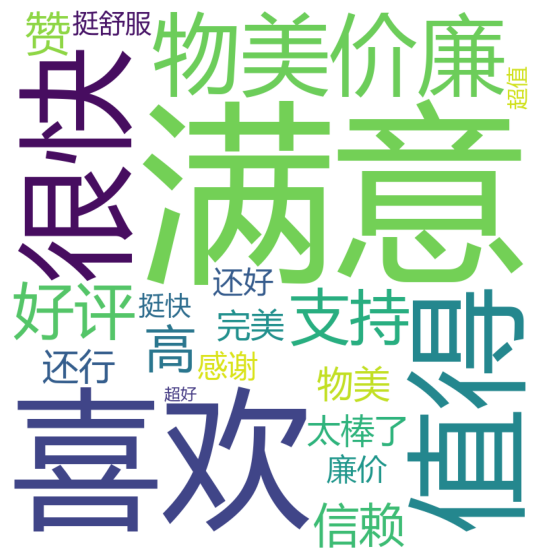

In [66]:
font=r"C:\Windows\Fonts\msyh.ttc"

background_image=plt.imread('./jd_P/p3.jpg')
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_pos.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<Figure size 1500x700 with 0 Axes>

(-0.5, 473.5, 363.5, -0.5)

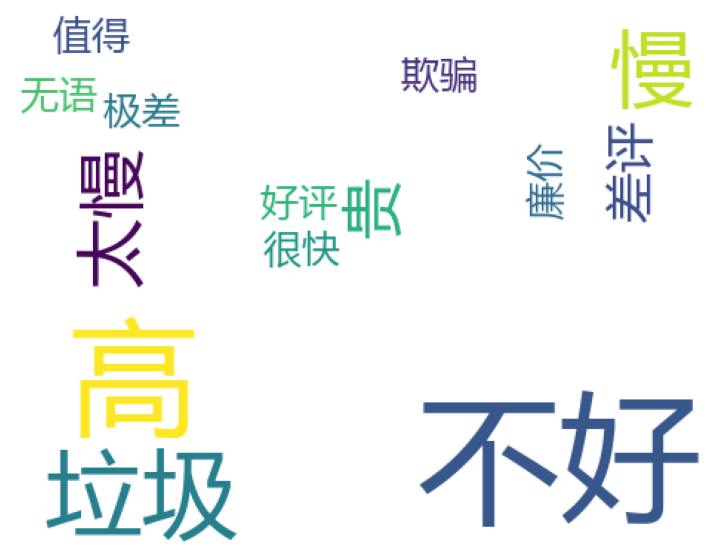

In [67]:
font=r"C:\Windows\Fonts\msyh.ttc"

background_image=plt.imread('./jd_P/p4.jpg')
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_neg.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

- 看所有词

<Figure size 1500x700 with 0 Axes>

(-0.5, 1344.5, 1344.5, -0.5)

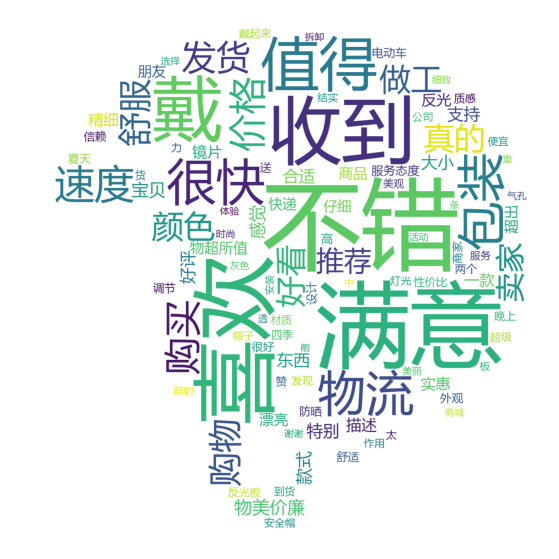

<Figure size 1500x700 with 0 Axes>

(-0.5, 1344.5, 1344.5, -0.5)

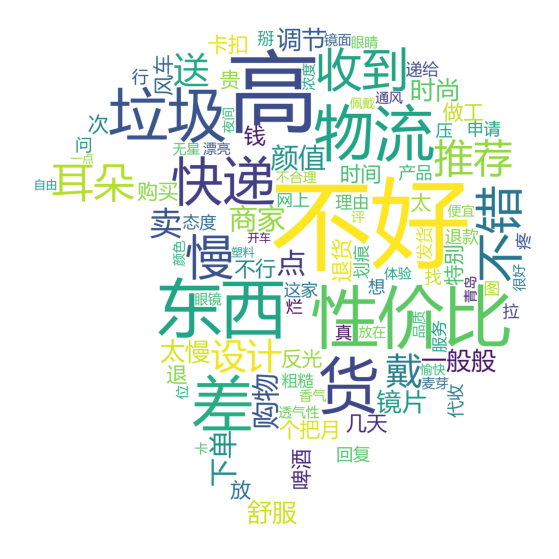

In [68]:
data=review_mltype.copy()

word_data_pos=data[data['ml_type']=='pos']
word_data_neg=data[data['ml_type']=='neg']

font=r"C:\Windows\Fonts\msyh.ttc"

background_image=plt.imread('./jd_P/p1.jpg')
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_pos.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

background_image=plt.imread('./jd_P/p1.jpg')
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_neg.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### （三）基于LDA模型的主题分析

优点：不需要人工调试，用相对少的迭代找到最优的主题结构。

（1）建立词典、语料库

In [69]:
data=review_mltype.copy()

word_data_pos=data[data['ml_type']=='pos']
word_data_neg=data[data['ml_type']=='neg']

In [70]:
#建立词典，去重

pos_dict=corpora.Dictionary([ [i] for i in word_data_pos.word]) #shape=(n,1)
neg_dict=corpora.Dictionary([ [i] for i in word_data_neg.word])

In [71]:
print(pos_dict)

Dictionary(930 unique tokens: ['黑色', '蓝色', '不错', '卖家', '发货']...)


In [72]:
#建立语料库

pos_corpus=[ pos_dict.doc2bow(j) for j in [ [i] for i in word_data_pos.word] ] #shape=(n,(2,1))
neg_corpus=[ neg_dict.doc2bow(j) for j in [ [i] for i in word_data_neg.word] ]

In [73]:
len(word_data_pos.word)
len(pos_dict)
len(pos_corpus)
pos_corpus  #元素是元组，元组（x,y),x是在词典中的位置，y是1表示存在。

3128

930

3128

[[(0, 1)],
 [(1, 1)],
 [(2, 1)],
 [(3, 1)],
 [(4, 1)],
 [(5, 1)],
 [(6, 1)],
 [(7, 1)],
 [(8, 1)],
 [(9, 1)],
 [(10, 1)],
 [(11, 1)],
 [(12, 1)],
 [(13, 1)],
 [(14, 1)],
 [(15, 1)],
 [(16, 1)],
 [(17, 1)],
 [(18, 1)],
 [(9, 1)],
 [(19, 1)],
 [(20, 1)],
 [(10, 1)],
 [(21, 1)],
 [(22, 1)],
 [(23, 1)],
 [(24, 1)],
 [(25, 1)],
 [(26, 1)],
 [(2, 1)],
 [(27, 1)],
 [(28, 1)],
 [(27, 1)],
 [(29, 1)],
 [(30, 1)],
 [(31, 1)],
 [(2, 1)],
 [(32, 1)],
 [(33, 1)],
 [(34, 1)],
 [(35, 1)],
 [(22, 1)],
 [(36, 1)],
 [(37, 1)],
 [(38, 1)],
 [(39, 1)],
 [(40, 1)],
 [(41, 1)],
 [(42, 1)],
 [(43, 1)],
 [(31, 1)],
 [(44, 1)],
 [(45, 1)],
 [(46, 1)],
 [(47, 1)],
 [(48, 1)],
 [(49, 1)],
 [(50, 1)],
 [(51, 1)],
 [(52, 1)],
 [(53, 1)],
 [(54, 1)],
 [(36, 1)],
 [(55, 1)],
 [(56, 1)],
 [(57, 1)],
 [(2, 1)],
 [(58, 1)],
 [(59, 1)],
 [(60, 1)],
 [(61, 1)],
 [(62, 1)],
 [(63, 1)],
 [(64, 1)],
 [(65, 1)],
 [(66, 1)],
 [(64, 1)],
 [(67, 1)],
 [(68, 1)],
 [(36, 1)],
 [(69, 1)],
 [(70, 1)],
 [(2, 1)],
 [(71, 1)],
 [(72, 

(2)主题数寻优


In [74]:
#构造主题数寻优函数

def cos(vector1,vector2):
    '''
    函数功能：余玄相似度函数
    '''
    dot_product=0.0
    normA=0.0
    normB=0.0
    for a,b in zip(vector1,vector2):
        dot_product +=a*b
        normA +=a**2
        normB +=b**2
    if normA==0.0 or normB==0.0:
        return None
    else:
        return ( dot_product/((normA*normB)**0.5) )

In [75]:
#主题数寻优
#这个函数可以重复调用，解决其他项目的问题

def LDA_k(x_corpus,x_dict):
    '''
    函数功能：
    '''
    #初始化平均余玄相似度
    mean_similarity=[]
    mean_similarity.append(1)
    
    #循环生成主题并计算主题间相似度
    for i in np.arange(2,11):
        lda=models.LdaModel(x_corpus,num_topics=i,id2word=x_dict) #LDA模型训练
        
        for j in np.arange(i):
            term=lda.show_topics(num_words=50)
        
        #提取各主题词
        top_word=[] #shape=(i,50)
        for k in np.arange(i):
            top_word.append( [''.join(re.findall('"(.*)"',i)) for i in term[k][1].split('+')]) #列出所有词
        
        #构造词频向量
        word=sum(top_word,[]) #列车所有词
        unique_word=set(word) #去重
        
        #构造主题词列表，行表示主题号，列表示各主题词
        mat=[] #shape=(i,len(unique_word))
        for j in np.arange(i):
            top_w=top_word[j]
            mat.append( tuple([ top_w.count(k) for k in unique_word ])) #统计list中元素的频次，返回元组
        
        #两两组合。方法一
        p=list(itertools.permutations(list(np.arange(i)),2)) #返回可迭代对象的所有数学全排列方式。
        y=len(p) # y=i*(i-1)
        top_similarity=[0]
        for w in np.arange(y):
            vector1=mat[p[w][0]]
            vector2=mat[p[w][1]]
            top_similarity.append(cos(vector1,vector2))

#        #两两组合，方法二
#        for x in range(i-1):
#            for y in range(x,i):
            
        #计算平均余玄相似度
        mean_similarity.append(sum(top_similarity)/ y)
    return mean_similarity

In [78]:
#计算主题平均余玄相似度

pos_k=LDA_k(pos_corpus,pos_dict)
neg_k=LDA_k(neg_corpus,neg_dict)

pos_k
neg_k

[1,
 0.2,
 0.006666666666666667,
 0.013333333333333334,
 0.01,
 0.030666666666666672,
 0.041904761904761924,
 0.07071428571428576,
 0.08666666666666664,
 0.11377777777777774]

[1,
 0.34,
 0.08,
 0.07666666666666667,
 0.09600000000000004,
 0.0826666666666667,
 0.06952380952380957,
 0.08214285714285716,
 0.06555555555555556,
 0.09599999999999995]

<AxesSubplot:>

Text(0.5, 1.0, '正面评论LDA主题数寻优')

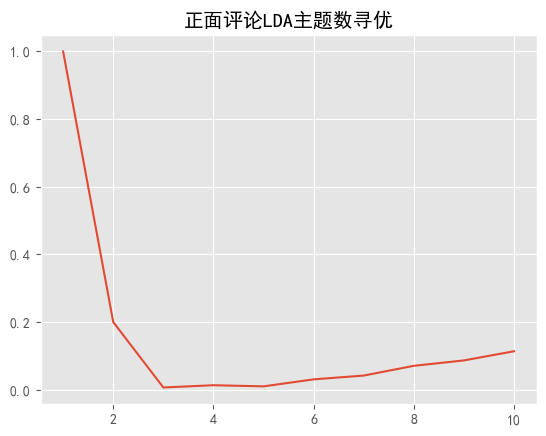

In [79]:
pd.Series(pos_k,index=range(1,11)).plot()
plt.title('正面评论LDA主题数寻优')
plt.show()

<AxesSubplot:>

Text(0.5, 1.0, '负面评论LDA主题数寻优')

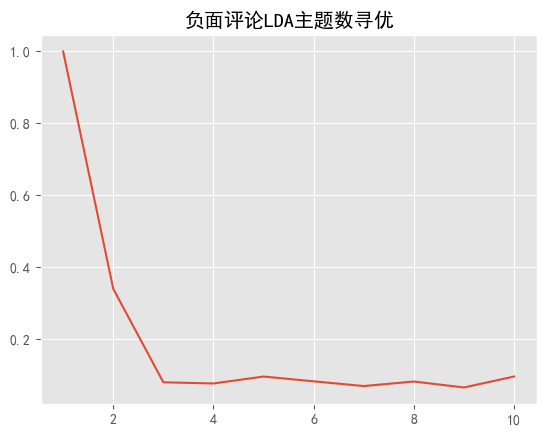

In [80]:
pd.Series(neg_k,index=range(1,11)).plot()
plt.title('负面评论LDA主题数寻优')
plt.show()

In [81]:
pos_lda=models.LdaModel(pos_corpus,num_topics=2,id2word=pos_dict)
neg_lda=models.LdaModel(neg_corpus,num_topics=2,id2word=neg_dict)
print("正面主题")
pos_lda.print_topics(num_topics=10)
print("负面主题")
neg_lda.print_topics(num_topics=10)

正面主题


[(0,
  '0.032*"喜欢" + 0.030*"满意" + 0.020*"值得" + 0.016*"收到" + 0.015*"速度" + 0.014*"做工" + 0.014*"购买" + 0.014*"戴" + 0.012*"发货" + 0.012*"购物"'),
 (1,
  '0.042*"不错" + 0.016*"物流" + 0.016*"价格" + 0.016*"很快" + 0.014*"颜色" + 0.014*"包装" + 0.013*"满意" + 0.012*"舒服" + 0.012*"真的" + 0.010*"宝贝"')]

负面主题


[(0,
  '0.026*"不好" + 0.013*"高" + 0.013*"差" + 0.010*"性价比" + 0.010*"收到" + 0.008*"垃圾" + 0.008*"设计" + 0.007*"太慢" + 0.007*"一般般" + 0.007*"快递"'),
 (1,
  '0.017*"高" + 0.013*"物流" + 0.012*"东西" + 0.012*"不好" + 0.011*"货" + 0.011*"性价比" + 0.009*"垃圾" + 0.009*"慢" + 0.008*"戴" + 0.008*"耳朵"')]